In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.util.shape import view_as_windows
import bioframe as bf
import bbi

In [2]:
# ignore log10(0) warnings
warnings.simplefilter("ignore", RuntimeWarning)

## Set plotting parameters

In [11]:
mpl.rcParams.update({'pdf.fonttype': 42,
                     'ps.fonttype': 42,
                     'xtick.labelsize': 32,
                     'ytick.labelsize': 32, 
                     'axes.labelsize':32,
                     'font.size': 22})

## Upload cross-scores calculated at 10 kb resolution

In [4]:
condition = 'WT'
distance = '30000-1000000'

chipMap = {"cis_ref" : f"./ref/fc_1_2_3_4_Old.ref.10000.cross.both.{distance}.bw",
            "cis_comp" : f"./comp/fc_1_2_3_4_Old.comp.10000.cross.both.{distance}.bw",
            "trans_comp_ref" : f"./comp_ref/fc_1_2_3_4_Old.comp_ref.10000.cross.both.{distance}.bw",
             "trans_ref_comp" : f"./ref_comp/fc_1_2_3_4_Old.ref_comp.10000.cross.both.{distance}.bw"}

## Upload SMC3 peaks and extend them to 1 Mb region of interest

In [5]:
center = 'ProteinX'
path = './data/MACS2/ProteinX.bed'
window = 500000 

In [6]:
proteinX = pd.read_csv(path, sep = '\t', index_col = False, header = None)[[0,1,2]]
proteinX.columns = ['chrom', 'start', 'end']
proteinX['mid'] = (proteinX.start + proteinX.end)//2
proteinX['upper'] = proteinX.mid - window
proteinX['lower'] = proteinX.mid + window
proteinX

,chrom,start,end,mid,upper,lower
0,chr1,9855,10614,10234,-489766,510234
1,chr1,10936,11845,11390,-488610,511390
2,chr1,15496,15732,15614,-484386,515614
3,chr1,90977,91957,91467,-408533,591467
4,chr1,104568,105527,105047,-394953,605047
...,...,...,...,...,...,...
34852,chrY,58994824,58995126,58994975,58494975,59494975
34853,chrY,58995181,58995371,58995276,58495276,59495276
34854,chrY,58996438,58996702,58996570,58496570,59496570
34855,chrY,58996849,58997207,58997028,58497028,59497028


## Calculate mean cross-score for each 10 kb bin within 1 Mb window with a center at SMC3 peak

In [7]:
bins = 100
cell_shape = (1,100)

x_scores = {}

for rType in ['cis_comp', 'cis_ref', 'trans_comp_ref', 'trans_ref_comp']: 
    x_scores[rType] = {}
    x_score = bbi.stackup (chipMap[rType], proteinX.chrom, proteinX.upper, proteinX.lower, bins)
    sections: np.ndarray = view_as_windows(x_score, cell_shape, cell_shape)
    x_score = np.nanmean(sections, axis = (-2,-1))
    x_scores[rType] = x_score

## Calculate asymmetry for cis and trans cross scores

In [8]:
asymmetry_cis = np.log2(x_scores['cis_comp']/x_scores['cis_ref']).flatten()
asymmetry_cis = asymmetry_cis[np.isfinite(asymmetry_cis)]

In [9]:
asymmetry_trans = np.log2(x_scores['trans_comp_ref']/x_scores['trans_ref_comp']).flatten()
asymmetry_trans = asymmetry_trans[np.isfinite(asymmetry_trans)]

## Plot asymmetry in cis and trans

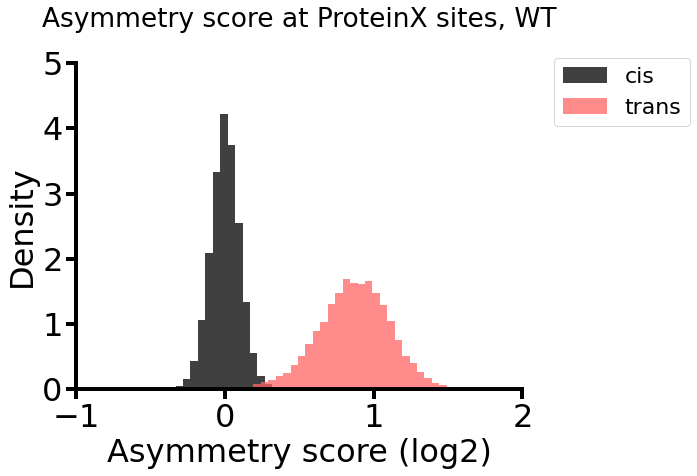

In [12]:
kws = dict(
    bins=100,
    histtype = 'bar'
)

colorMap = {'cis': '0', 'trans': '#ff6464'}

f, axs = plt.subplots(
    figsize=(8, 6),
    nrows=1, 
    ncols=1)

width = 0.05

plt.hist(asymmetry_cis, 
         bins=np.arange(min(asymmetry_cis), max(asymmetry_cis) + width, width), 
         color = colorMap['cis'], 
         alpha = 0.75, 
         label = 'cis', 
         density=True)

plt.hist(asymmetry_trans, 
         bins=np.arange(min(asymmetry_trans), max(asymmetry_trans) + width, width), 
         color = colorMap['trans'], 
         alpha = 0.75, 
         label = 'trans', 
         density=True);

plt.gca().spines['left'].set_linewidth(4)
plt.gca().spines['bottom'].set_linewidth(4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params('both', length=10, width=4, which='major')
plt.xlim (-1, 2)
plt.ylim (0, 5)
plt.title (f'Asymmetry score at ProteinX sites, {condition}\n') 
plt.xlabel ('Asymmetry score (log2)')
plt.ylabel ('Density')
plt.legend(bbox_to_anchor=(1.4, 1.05))
plt.show();